# 1D linearized shallow-water equation with wind stress


In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate(".")
#Pkg.resolve(); Pkg.instantiate(); Pkg.precompile()  # Uncomment if needed for reproducibility

using OrdinaryDiffEq, ComponentArrays, Plots, JLD2, Flux, Random, Statistics, ProgressMeter, StatsBase, ParameterSchedulers, BSON, Optimisers, Optim, Zygote
using ParameterSchedulers: Stateful
using Flux: Adam

  Activating project at `~/Desktop/Deltares/Final Report Code/Model-2`


In [2]:
const SEED = rand(UInt) 
Random.seed!(SEED); println("Using seed = $SEED")

# There are several surrogate models trained with different configurations:
# short runtimes 
#   -> surrogate 1 (report 2.1) - short multi_scale  [0.9, 1.0, 1.2] 
#   -> surrogate 2 (report 1)   - short multi_scale  [0.6 , 0.7, … , 1.3, 1.4] 
#   -> surrogate 3 (report ?)   - short multi_scale  [0.9, 1.0, 1.2]
#   -> surrogate 4 (report ?)   - short multi_scale  [0.7, 0.9, 1.0, 1.2, 1.3] 
#   -> surrogate 5 (report 3.1) - short multi_init   [0.9, 1.0, 1.2] 
# longer runtimes
#   -> surrogate 1 (report ?)   - longer multi_scale [0.9, 1.0, 1.2] 
#   -> surrogate 2 (report 2.2) - longer multi_scale [0.9, 1.0, 1.2] 
#   -> surrogate 3 (report ?)   - longer multi_init  [0.7, 0.8, 0.9, 1.0, 1.2, 1.3, 1.5] 
#   -> surrogate 5 (report 3.2) - long multi_scale   [0.9, 1.0, 1.2] 

# Surrogate to show
surrogate = 2 
wind_name = "periodic"            # periodic only for experiments here
correction_init_state = "flat"    # flat or bump or small_bump
longer = false                     # true for longer simulation time 

# Surrogate model configuration
use_multi_init = false     # several initial conditions training
predict_increment = true   # false to predict absolute
use_multi_data = true      # several wind amplitudes training 

# Directories
save_folder = "surrogates"     
results_dir = joinpath(save_folder, "Surrogate_$surrogate")
mkpath(results_dir) 

@show wind_name, correction_init_state, longer, predict_increment, use_multi_data, use_multi_init
nothing 

Using seed = 7206162677145923426
(wind_name, correction_init_state, longer, predict_increment, use_multi_data, use_multi_init) = ("periodic", "flat", false, true, true, false)


#### Setup

In [3]:
const DEBUG = true
const use_gpu = false

function debug(msg, override::Bool=DEBUG)
    if override
        println(msg)
    end
end

to_device(x) = x
if use_gpu
    try
        using CUDA
        println("CUDA is available. Using GPU.")
        CUDA.seed!(SEED)
        to_device(x) = gpu(x)
    catch e
        println("CUDA.jl not found or error loading it. Using CPU. Error: $e")
    end
else
    println("Using CPU.")
end


Using CPU.


In [4]:
include("model_1d_surge_wave.jl")
include("wind_forcing_functions.jl") 
include("normalization-utils.jl")

colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

In [5]:
# utils
function constant_func(t, value=0.0)
    return value
end

function run_model_and_extract(f::Wave1DSurge_cpu, x0, times, station_idxs)
    prob = ODEProblem(f, x0, (times[1], times[end]))
    sol = solve(prob, Rodas5(), saveat = times, isoutofdomain = (u, p, t) -> any([u.h[i] + D[i] < 0 for i in 1:length(u.h)]), reltol = 1e-8, abstol = 1e-10)

    n_time = length(times)
    n_stat = length(station_idxs)
    Y = zeros(n_time, n_stat)
    U = zeros(n_time, n_stat)

    for (i, t) in enumerate(times)
        state = sol(t)
        Y[i, :] = state.h[station_idxs]
        U[i, :] = state.u[station_idxs]
    end

    return sol, Y, U
end

function make_tau(amplitude=1.0, period=8*3600.0)
    return t -> (amplitude * sin(2π * t / period))^2
end

q_left(t) = constant_func(t, 0.0)
q_right(t) = constant_func(t, 0.0)


q_right (generic function with 1 method)

#### Numerical Simulation and Model Data

In [6]:
# Import surrogate model data 
if longer 
    @load "data/multidata_$(correction_init_state)_$(wind_name)_surrogate_$(surrogate)-longer.jld2" surrogate_model H_surrogate surrogate_data
    println("loaded surrogate model data at data/multidata_$(correction_init_state)_$(wind_name)_surrogate_$(surrogate)-longer.jld2")
else 
    @load "data/multidata_$(correction_init_state)_$(wind_name)_surrogate_$(surrogate).jld2" surrogate_model H_surrogate surrogate_data
    println("loaded surrogate model data at data/multidata_$(correction_init_state)_$(wind_name)_surrogate_$(surrogate).jld2")
end 

for (k, v) in surrogate_data
    eval(:($(Symbol(k)) = $v))
end

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end
nothing

loaded surrogate model data at data/multidata_flat_periodic_surrogate_2.jld2


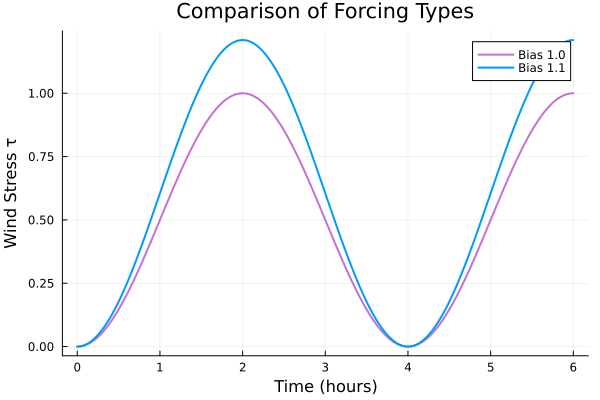

In [7]:
# Create wind stress forcings to compare base vs biased
if wind_name == "AR(2)"
    # Autoregressive process of order 2
    tau_nominal = make_tau_ar(amplitude=amplitude, coeffs=coeffs, sigma=sigma, seed=wind_seed)
    tau_true = make_tau_ar(amplitude=(amplitude * bias_factor), coeffs=coeffs, sigma=sigma, seed=wind_seed)

elseif wind_name == "piecewise"
    # Piecewise constant forcing with noise
    tau_nominal = make_tau_piecewise(amplitude=amplitude, avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed) 
    tau_true = make_tau_piecewise(amplitude=(amplitude * bias_factor), avg_duration=avg_duration, noise_level=0.3, seed=wind_seed)

elseif wind_name == "zero"
    # No wind forcing
    tau_nominal = make_tau_zero() 
    tau_true = make_tau_zero() 

elseif wind_name == "constant"
    # Constant wind stress
    tau_nominal = make_tau_constant(amplitude=amplitude)
    tau_true = make_tau_constant(amplitude=(amplitude * bias_factor))

elseif wind_name == "periodic"
    # Single-frequency periodic forcing
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)

elseif wind_name == "multi-frequency" 
    # Multi-frequency forcing with weighted components
    tau_nominal = make_tau_multifreq(amplitude=amplitude, periods=periods, weights=weights, seed=wind_seed)
    tau_true = make_tau_multifreq(amplitude=(amplitude * bias_factor), periods=periods, weights=weights, seed=wind_seed)
else 
    # Default fallback: periodic forcing
    wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)
end

p = compare_forcings(Dict("Bias 1.0" => tau_nominal,"Bias $bias_factor" => tau_true), times)
#savefig(p, "report_plots/wind_stress_bias_comparison.png")
display(p)

In [8]:
function rollout_surrogate(surrogate_model, h0, u0, times, tau_func, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, amplitude_scale, init_condition=correction_init_state)
    """
    Perform a rollout using the surrogate model over the given time grid
    Inputs:
        surrogate_model  - trained surrogate (e.g. neural net)
        h0, u0           - initial states (arrays per station)
        times            - vector of time points
        tau_func         - function returning τ(t) forcing at time t
        mu_X, sigma_X    - normalization stats for inputs
        mu_Y, sigma_Y    - normalization stats for outputs
        D_stations       - station-specific features (e.g. distances)
        mask             - station mask (active/inactive flags)
        n_stations       - number of stations
        amplitude_scale  - global scaling factor
        init_condition   - initial condition label (for multi-IC surrogates)

    Return: full rollout trajectories
    """

    # Initialize prediction arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1,:] = h0
    u_pred[1,:] = u0

    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))

    # Encode initial condition if using multi-IC surrogate
    ic_vec = nothing
    if use_multi_init
        ic_vec = zeros(Float32, n_init_conditions)
        ic_vec[ic_to_idx[init_condition]] = 1.0f0
    end

    # Rollout loop over time steps
    for k in 1:(length(times) - 1)
        # Build raw input vector for this step
        input_vec = Float32[]
        tau_val = Float32(tau_func(times[k]))
        
        # Collect local features for each station
        for i in 1:n_stations
            append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_val, amplitude_scale])
        end

        # Append IC encoding if applicable
        if ic_vec !== nothing
            append!(input_vec, ic_vec)
        end
        
        # Normalize inputs
        input_norm = copy(input_vec)
        input_norm[norm_cols_X] = (input_vec[norm_cols_X] .- mu_X) ./ sigma_X
        input_norm[mask_cols_X] = input_vec[mask_cols_X]
        
        input_col = reshape(Float32.(input_norm), :, 1)

        # Surrogate prediction
        pred_norm = surrogate_model(input_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize output
        pred_unnorm = copy(pred_vec)
        pred_unnorm[norm_cols_Y] = pred_vec[norm_cols_Y] .* sigma_Y .+ mu_Y

        # Update state
        if predict_increment
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end

    return h_pred, u_pred  
end

rollout_surrogate (generic function with 2 methods)

In [9]:
# Load model parameters
if longer 
    @load "data/$(correction_init_state)_$(wind_name)_longer_parameters.jld2" params
else 
    @load "data/$(correction_init_state)_$(wind_name)_parameters.jld2" params 
end 

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

# Generate 'true' data (observations from the true model)
println("\nGenerating TRUE data (with scale=$bias_factor)...")
f_true = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_true, q_left, q_right)
sol_true, H_true, U_true = run_model_and_extract(f_true, x0, times, station_idxs)

# Generate surrogate training data 
println("\nGenerating surrogate data (with no scale)...")
f_nominal = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_nominal, q_left, q_right)
sol_nominal, H_nominal, U_nominal = run_model_and_extract(f_nominal, x0, times, station_idxs)

nothing


Generating TRUE data (with scale=1.1)...

Generating surrogate data (with no scale)...


In [10]:
# Convert normalization parameters
mu_X = Float32.(mu_X)
sigma_X = Float32.(sigma_X)
mu_Y = Float32.(mu_Y)
sigma_Y = Float32.(sigma_Y)
nothing

#### Visualization of Surrogate Performance

In [11]:
@show TRAIN_SCALES, use_multi_data, use_multi_init, surrogate_seed

# Original surrogate (no correction)
H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, mu_X, sigma_X, mu_Y, sigma_Y,
                                             D_stations, mask, n_stations, 1.0f0, correction_init_state)

nothing

(TRAIN_SCALES, use_multi_data, use_multi_init, surrogate_seed) = ([0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4], true, false, 18381078987248293814)


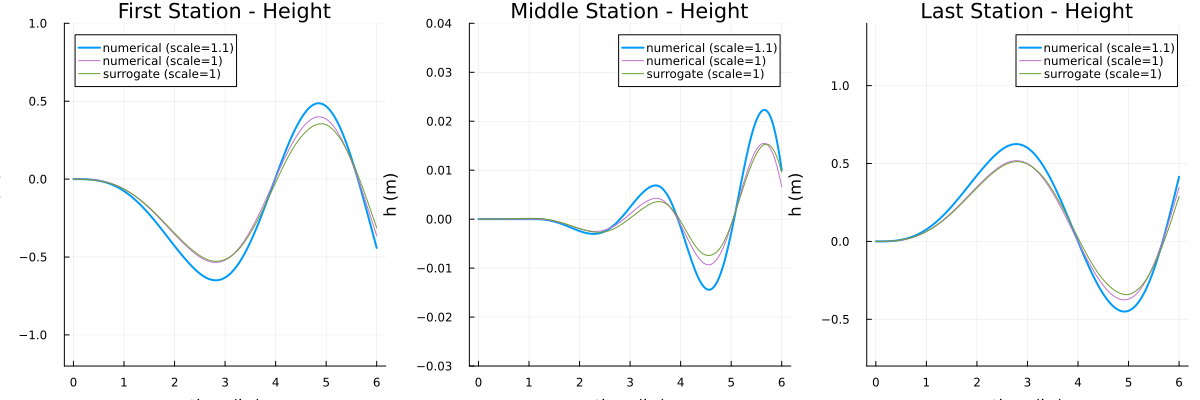

In [12]:
# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
ylims = [(-1.2, 1.0), (-0.03, 0.04), (-0.8, 1.4)]
titles = ["First Station - Height", "Middle Station - Height", "Last Station - Height"]

# Create the 3-panel layout
plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true[:, s], label="numerical (scale=$bias_factor)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])    
    xlabel!(plt[i], "time (hr)"); ylabel!(plt[i], "h (m)"); title!(plt[i], titles[i])
end
savefig(plt, joinpath(results_dir,"stationcomparison_surrogate$(surrogate)_$(longer).png"))
display(plt)
nothing

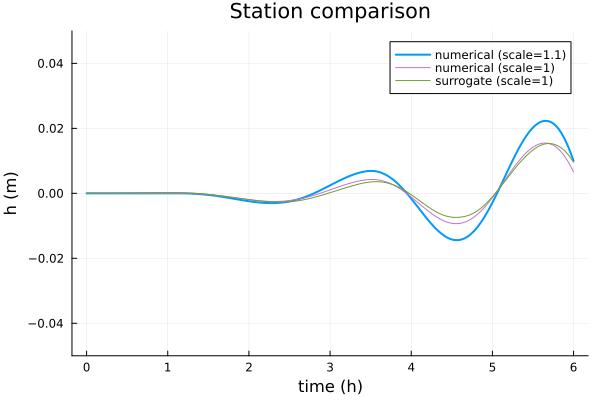

In [13]:
#rollout comparison at a station s
s = station_idxs[end ÷ 2]
p = plot(times./3600, H_true[:, s], label="numerical (scale=$bias_factor)", lw=2, ylim=(-0.05, 0.05))
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Station comparison")
savefig(joinpath(results_dir,"middlestation_surrogate$(surrogate)_$(longer).png"))
display(p)

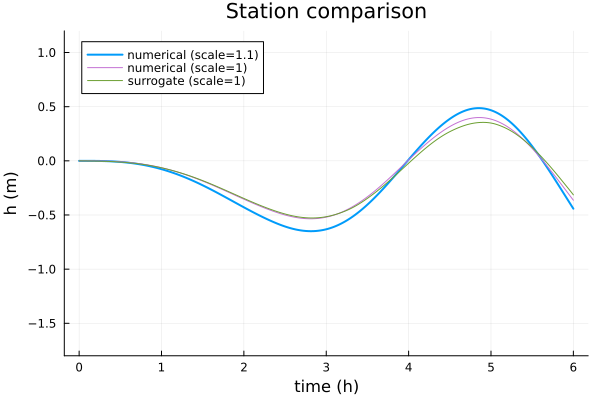

In [14]:
#rollout comparison at a station s
s = station_idxs[1]
p = plot(times./3600, H_true[:, s], label="numerical (scale=$bias_factor)", lw=2, ylim=(-1.8, 1.2))
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Station comparison")
savefig(joinpath(results_dir,"firststation_surrogate$(surrogate)_$(longer).png"))
display(p)

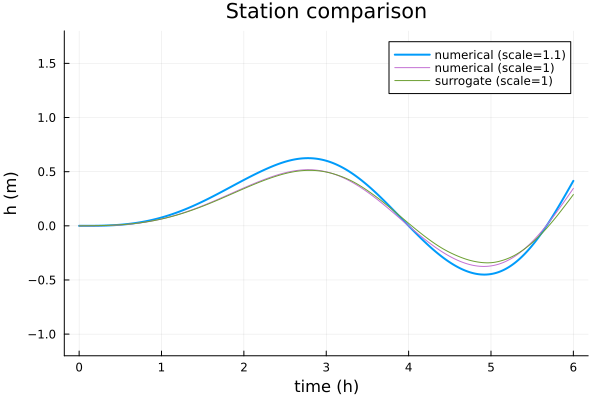

In [15]:
#rollout comparison at a station s
s = station_idxs[end]
p = plot(times./3600, H_true[:, s], label="numerical (scale=$bias_factor)", lw=2, ylim=(-1.2, 1.8))
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("Station comparison")
savefig(joinpath(results_dir,"laststation_surrogate$(surrogate)_$(longer).png"))
display(p)

### Test with new wind forcing

In [16]:
bias_test = 1.1
state_test = "flat"
nothing

In [17]:
println("\nRunning true simulation for $state_test with bias factor $bias_test...")

# Load model parameters for test case
if longer
    @load "data/$(state_test)_$(wind_name)_longer_parameters.jld2" params
else
    @load "data/$(state_test)_$(wind_name)_parameters.jld2" params
end

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

# test wind forcing 
if wind_name == "piecewise"
    tau_test = make_tau_piecewise(amplitude=(amplitude * bias_test), avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed)
elseif wind_name == "periodic"
    tau_test = make_tau_periodic((amplitude * bias_test), period)
elseif wind_name == "multi-frequency" 
    tau_test = make_tau_multifreq(amplitude=(amplitude * bias_test), periods=periods, weights=weights, seed=wind_seed)
end

# Run true model with the test parameters 
f_test = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_test, q_left, q_right)
@time sol_test, H_true_test, U_true_test = run_model_and_extract(f_test, x0, times, station_idxs)
@time Y_test, U_test = rollout_surrogate(surrogate_model, H_true_test[1, :], U_true_test[1, :], times, tau_test, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, bias_test)

nothing


Running true simulation for flat with bias factor 1.1...
  1.327296 seconds (2.11 M allocations: 852.033 MiB, 15.95% gc time)
  0.221094 seconds (1.31 M allocations: 49.549 MiB, 3.63% gc time, 73.89% compilation time)


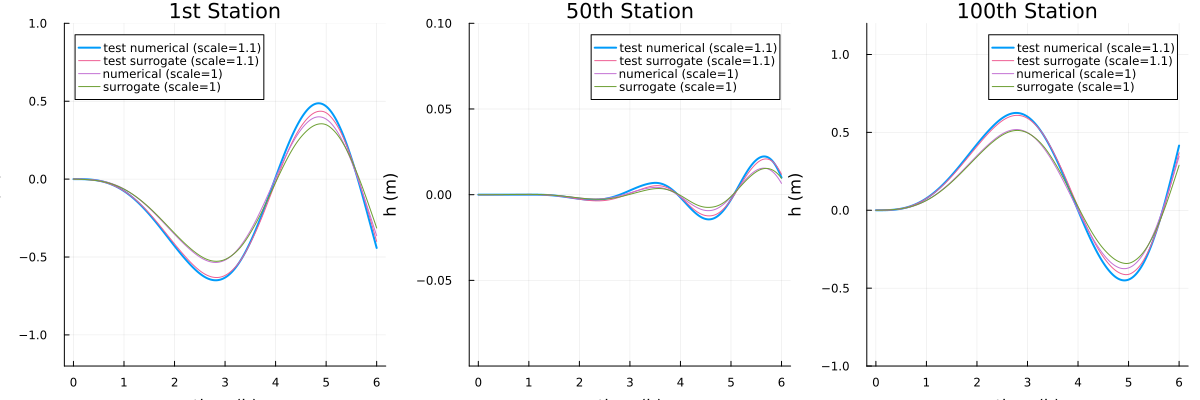

"/Users/sara/Desktop/Deltares/Final Report Code/Model-2/surrogates/Surrogate_2/flat_rollout_with_true_surrogate2_false.png"

In [18]:
# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
ylims = [(-1.2, 1.0), (-0.1, 0.1), (-1.0, 1.2)]
titles = ["1st Station", "50th Station", "100th Station"]

# Create the 3-panel layout
plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true_test[:, s], label="test numerical (scale=$bias_test)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, Y_test[:, s], label="test surrogate (scale=$bias_test)", color=cur_colors[7])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
    xlabel!(plt[i], "time (h)")
    ylabel!(plt[i], "h (m)")
    title!(plt[i], titles[i])
end

# Optionally save the figure
display(plt)
savefig(joinpath(results_dir,"$(init_state)_rollout_with_true_surrogate$(surrogate)_$(longer).png"))

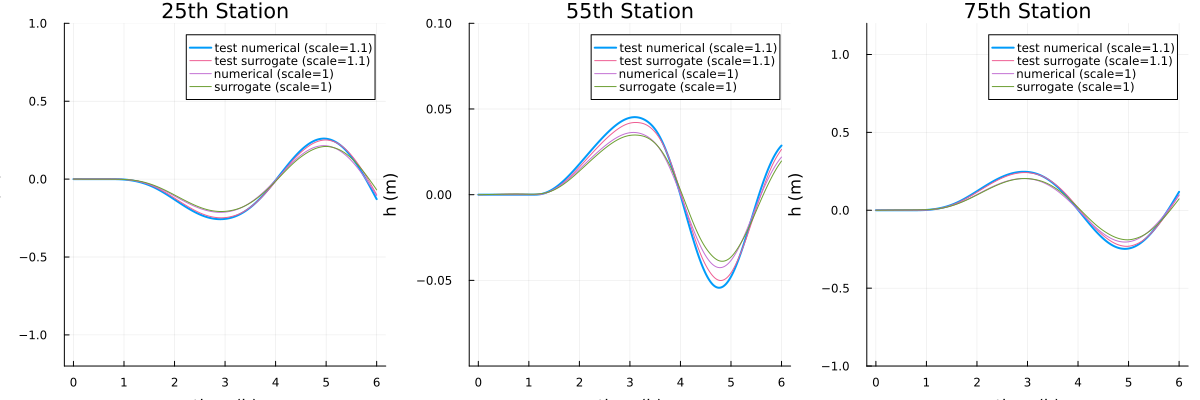

In [19]:
# Prepare the station indices
stations = [station_idxs[end ÷ 4], station_idxs[end ÷ 2]+5, station_idxs[3 * end ÷ 4]]
ylims = [(-1.2, 1.0), (-0.1, 0.1), (-1.0, 1.2)]
titles = ["25th Station", "55th Station", "75th Station"]

# Create the 3-panel layout
plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true_test[:, s], label="test numerical (scale=$bias_test)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, Y_test[:, s], label="test surrogate (scale=$bias_test)", color=cur_colors[7])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
    xlabel!(plt[i], "time (h)")
    ylabel!(plt[i], "h (m)")
    title!(plt[i], titles[i])
end

savefig(plt, joinpath(results_dir,"$(init_state)_rollout2_with_true_surrogate$(surrogate)_$(longer).png"))
display(plt)

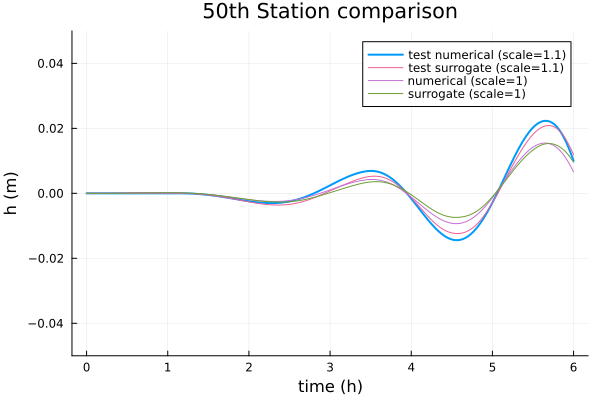

In [20]:
#rollout comparison at a station s
s = station_idxs[end ÷ 2]
p = plot(times./3600, H_true_test[:, s], label="test numerical (scale=$bias_test)", lw=2, ylim=(-0.05, 0.05))
plot!(times./3600, Y_test[:, s], label="test surrogate (scale=$bias_test)", color=cur_colors[7])
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("$(s)th Station comparison")
savefig(joinpath(results_dir,"middlestation2_surrogate$(surrogate)_$(longer).png"))
display(p)

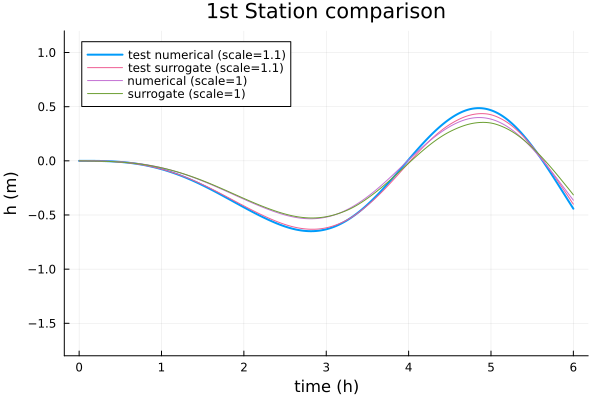

In [21]:
#rollout comparison at a station s
s = station_idxs[1]
p = plot(times./3600, H_true_test[:, s], label="test numerical (scale=$bias_test)", lw=2, ylim=(-1.8, 1.2))
plot!(times./3600, Y_test[:, s], label="test surrogate (scale=$bias_test)", color=cur_colors[7])
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("$(s)st Station comparison")
savefig(joinpath(results_dir,"firststation2_surrogate$(surrogate)_$(longer).png"))
display(p)

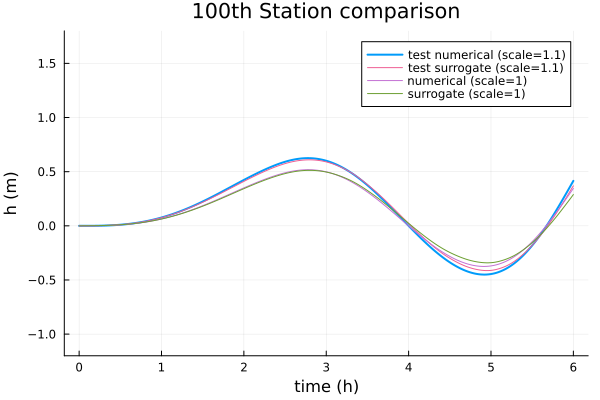

In [22]:
#rollout comparison at a station s
s = station_idxs[end]
p = plot(times./3600, H_true_test[:, s], label="test numerical (scale=$bias_test)", lw=2, ylim=(-1.2, 1.8))
plot!(times./3600, Y_test[:, s], label="test surrogate (scale=$bias_test)", color=cur_colors[7])
plot!(times./3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
plot!(times./3600, H_surrogate[:, s], label="surrogate (scale=1)", color=cur_colors[end])
xlabel!("time (h)"); ylabel!("h (m)"); title!("$(s)th Station comparison")
savefig(joinpath(results_dir,"laststation2_surrogate$(surrogate)_$(longer).png"))
display(p)

In [23]:
# Compute RMSE statistics
println("\n=== RMSE Statistics ===")

# RMSE between surrogate (scale=1) and truth (scale=1)
rmse_surrogate_scale1 = sqrt(mean((H_surrogate .- H_nominal).^2))
rmse_surrogate_scale1_stations = sqrt.(mean((H_surrogate .- H_nominal).^2, dims=1))

# RMSE between surrogate (scale=1) and truth (scale=1.1)
rmse_surrogate_true = sqrt(mean((H_surrogate .- H_true).^2))

# RMSE between surrogate (scale=1.1) and truth (scale=1.1)  
rmse_surrogate_scale11 = sqrt(mean((Y_test .- H_true_test).^2))
rmse_surrogate_scale11_stations = sqrt.(mean((Y_test .- H_true_test).^2, dims=1))

println("Overall RMSE - Surrogate (scale=1) vs Truth (scale=1.1): $(round(rmse_surrogate_true, digits=6))")
println("Overall RMSE - Surrogate (scale=1) vs Nominal (scale=1): $(round(rmse_surrogate_scale1, digits=6))")
println("Overall RMSE - Surrogate (scale=1.1) vs Truth (scale=1.1): $(round(rmse_surrogate_scale11, digits=6))")

# Also compute RMSE for the specific stations shown in plots
key_stations = [station_idxs[1], station_idxs[end÷4], station_idxs[end÷2], station_idxs[3*end÷4],station_idxs[end]]

println("\n=== Station-wise Temporal RMSE ===")
for i in key_stations
    println(" RMSE at Station $i:")
    println("  Scale 1: $(round(rmse_surrogate_scale1_stations[i], digits=6))")
    println("  Scale 1.1: $(round(rmse_surrogate_scale11_stations[i], digits=6))\n")
end


=== RMSE Statistics ===
Overall RMSE - Surrogate (scale=1) vs Truth (scale=1.1): 0.042462
Overall RMSE - Surrogate (scale=1) vs Nominal (scale=1): 0.012581
Overall RMSE - Surrogate (scale=1.1) vs Truth (scale=1.1): 0.012447

=== Station-wise Temporal RMSE ===
 RMSE at Station 1:
  Scale 1: 0.022513
  Scale 1.1: 0.023809

 RMSE at Station 25:
  Scale 1: 0.00988
  Scale 1.1: 0.009055

 RMSE at Station 50:
  Scale 1: 0.000801
  Scale 1.1: 0.001102

 RMSE at Station 75:
  Scale 1: 0.009729
  Scale 1.1: 0.009391

 RMSE at Station 100:
  Scale 1: 0.019522
  Scale 1.1: 0.019385

